# IDS Week 14_2: Text Classification with Sentence Embeddings & Logistic Regression

In this notebook, we’ll walk step-by-step through building a movie-review classifier on the Rotten Tomatoes dataset using pretrained sentence embeddings and scikit-learn’s Logistic Regression. We’ll cover:

1. **Environment Setup** – install and import libraries.  
2. **Load & Inspect Data** – load the Rotten Tomatoes reviews and take a first look.  
3. **Generate Embeddings** – encode each review into a fixed-size vector via sentence-transformers.  
4. **Train/Test Split** – partition our data for training and evaluation.  
5. **Train Classifier** – fit a Logistic Regression model on embedding features.  
6. **Evaluate Performance** – compute accuracy, confusion matrix, and classification report.  
7. **Interpret Results** – inspect model coefficients and predicted probabilities.  

## **Step 1: Environment Setup**

First, install the required libraries (`sentence-transformers` for embeddings, `datasets` for loading our data) and import everything we need.

In [1]:
# Install sentence-transformers for easy embeddings
!pip install sentence-transformers
# Install the Hugging Face datasets library to load Rotten Tomatoes reviews
!pip install datasets

   ---------------------------------------- 0.0/212.5 MB ? eta -:--:--
   - -------------------------------------- 7.6/212.5 MB 36.2 MB/s eta 0:00:06
   -- ------------------------------------- 13.1/212.5 MB 31.6 MB/s eta 0:00:07
   --- ------------------------------------ 20.7/212.5 MB 31.9 MB/s eta 0:00:07
   ----- ---------------------------------- 27.0/212.5 MB 31.7 MB/s eta 0:00:06
   ------ --------------------------------- 34.1/212.5 MB 32.3 MB/s eta 0:00:06
   ------- -------------------------------- 41.4/212.5 MB 32.1 MB/s eta 0:00:06
   --------- ------------------------------ 48.0/212.5 MB 31.8 MB/s eta 0:00:06
   ---------- ----------------------------- 55.3/212.5 MB 32.3 MB/s eta 0:00:05
   ----------- ---------------------------- 62.1/212.5 MB 32.2 MB/s eta 0:00:05
   ------------- -------------------------- 69.2/212.5 MB 32.2 MB/s eta 0:00:05
   -------------- ------------------------- 75.5/212.5 MB 32.1 MB/s eta 0:00:05
   --------------- ------------------------ 83.1/2

## **Step 2: Load & Inspect Data**
We’ll load the [Cornell Movie Review “Rotten Tomatoes” dataset](https://huggingface.co/datasets/cornell-movie-review-data/rotten_tomatoes) (just the training split for sample size purposes) and convert it to a pandas DataFrame for easy inspection.
- `label = 1` means "fresh"
- `label = 0` means "rotten"

In [4]:
import numpy as np
import pandas as pd
from datasets import load_dataset

# Load the Rotten Tomatoes dataset
dataset = load_dataset("cornell-movie-review-data/rotten_tomatoes", split="train")
df = dataset.to_pandas()
df

,text,label
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1
...,...,...
8525,any enjoyment will be hinge from a personal th...,0
8526,if legendary shlockmeister ed wood had ever ma...,0
8527,hardly a nuanced portrait of a young woman's b...,0
8528,"interminably bleak , to say nothing of boring .",0


In [5]:
# Check class distribution to ensure balance
df["label"].value_counts()

label
1    4265
0    4265
Name: count, dtype: int64

## **Step 3: Generate Sentence Embeddings**
We use the [`SentenceTransformer` wrapper](https://huggingface.co/sentence-transformers), which exposes a simple `.encode()` method. It returns an (n_samples × embedding_dim) NumPy array.

In [10]:
# sentence-transformers for pretrained encoder
from sentence_transformers import SentenceTransformer

# Instantiate the pretrained embedding model
model_name = "sentence-transformers/all-MiniLM-L6-v2"
embedder = SentenceTransformer(model_name)

# Encode all review texts to embeddings
# convert_to_numpy=True returns a NumPy array
# show_progress_bar displays encoding progress
X_embs = embedder.encode(
    df["text"].to_list(), 
    convert_to_numpy= True,
    show_progress_bar= True)
# Inspect shape: (n_reviews, embedding_dimension)
print("Embeddings shape:", X_embs.shape)


Batches:   0%|          | 0/267 [00:00<?, ?it/s]

Embeddings shape: (8530, 384)


## **Step 4: Split into Training & Testing Sets**
We’ll hold out 20% of our embeddings/labels for testing, using a fixed random_state for reproducibility.

In [11]:
from sklearn.model_selection import train_test_split
# Define features (embeddings) and target (labels)
y = df["label"].to_numpy()

# Split embeddings and labels into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_embs,
    y,
    test_size=.2,
    random_state=42
)

# Confirm sizes
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples:     {X_test.shape[0]}")

Training samples: 6824
Test samples:     1706


## **Step 5: Train Logistic Regression**
Fit a logistic regression classifier on our training set. We use the default L2 penalty and solver, and let `scikit-learn` choose sensible defaults.

In [12]:
from sklearn.linear_model import LogisticRegression

# Initialize the logistic regression model
clf = LogisticRegression()

# Train on embedding features
clf.fit(X_train, y_train)

LogisticRegression()

## **Step 6: Evaluate Performance**
We’ll predict on the test set, compute overall accuracy, plot the confusion matrix, and print a detailed classification report (precision, recall, F1-score).

0.7596717467760844

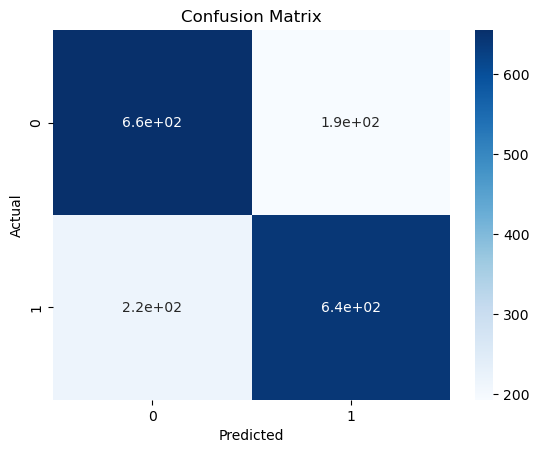

              precision    recall  f1-score   support

           0       0.75      0.77      0.76       848
           1       0.77      0.75      0.76       858

    accuracy                           0.76      1706
   macro avg       0.76      0.76      0.76      1706
weighted avg       0.76      0.76      0.76      1706



In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 
import seaborn as sns

# Predict on test data
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
display(accuracy)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, cmap = "Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Display classification report
print(classification_report(y_test, y_pred))

## **Step 7: Predict New Texts**
Now that we have a trained model, let’s see how it does on user-supplied reviews. We’ll:

1. Define a few custom review strings.  
2. Encode them into embeddings.  
3. Predict labels and class-probabilities with our logistic regressor.  
4. Print out each review with its predicted sentiment and confidence.

In [ ]:
# 7.1 Define some new reviews to classify as a list


# 7.2 Generate embeddings for these new texts
# (using the same embedder we initialized earlier)


# 7.3 Predict labels and probabilities


# 7.4 Display results
